In [6]:
import pandas as pd

DIV = pd.read_excel (r'/Users/joezhou/Downloads/ALL_Div.xlsx') 

#create a baselist for adding on the feature engineered variables
TICKER_LIST = DIV['TickName'].drop_duplicates().reset_index(drop=True)


In [8]:
# Calculate volatility features
DIV_MEDIAN = DIV.groupby("TickName")["Dividends"].median()
DIV_STD = DIV.groupby("TickName")["Dividends"].std()
DIV_MIN = DIV.groupby("TickName")["Dividends"].min()
DIV_MAX = DIV.groupby("TickName")["Dividends"].max()


TICKER_LIST_ADDED = pd.merge(TICKER_LIST,DIV_MEDIAN,on='TickName').rename(columns={'Dividends': 'Dividends_Median'})

TICKER_LIST_ADDED = pd.merge(TICKER_LIST_ADDED,DIV_STD,on='TickName').rename(columns={'Dividends': 'Dividends_Std'})

TICKER_LIST_ADDED = pd.merge(TICKER_LIST_ADDED,DIV_MIN,on='TickName').rename(columns={'Dividends': 'Dividends_Min'})

TICKER_LIST_ADDED = pd.merge(TICKER_LIST_ADDED,DIV_MAX,on='TickName').rename(columns={'Dividends': 'Dividends_Max'})


<AxesSubplot:xlabel='Dividends_Min', ylabel='Dividends_Median'>

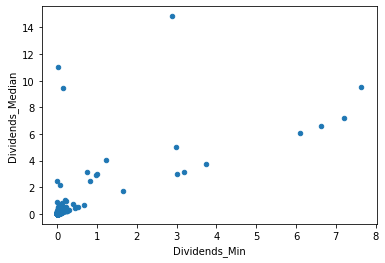

In [13]:
import matplotlib.pyplot as plt

# TICKER_LIST_ADDED.plot('Dividends_Median','Dividends_Std',kind = 'scatter')
# TICKER_LIST_ADDED.plot('Dividends_Min','Dividends_Max',kind = 'scatter')
TICKER_LIST_ADDED.plot('Dividends_Min','Dividends_Median',kind = 'scatter')



In [10]:
TICKER_LIST_ADDED.to_excel('/Users/joezhou/Downloads/ALL_Div_FEATURES.xlsx')  
